In [1]:
import warnings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings('ignore')  # Игнорировать все предупреждения (не рекомендуется в продакшн-коде)
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from numpy import mean
from numpy import var
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from causalinference import CausalModel
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import tt_ind_solve_power
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from causalinference import CausalModel
import imp
import help_tools as ht
import ci_tools as ci

#### TODO

изучить функционал библиотек  
https://github.com/pyro-ppl/pyro  
https://github.com/py-why/dowhy  
https://github.com/uber/causalml  

Ключевая книга  по causal inference
https://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html  

Ссылки на датасеты  
https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/collections_email.csv  

Чекнуть книгу:  
Inference and Intervention Causal Models for Business Analysis  
    
https://www.kaggle.com/code/harrywang/simple-matching-in-python  
https://habr.com/ru/companies/ods/articles/544208/   
https://harrywang.me/psm-did  
Цикл статей о казуальности: https://towardsdatascience.com/why-do-we-need-causality-in-data-science-aec710da021e  
Методы используемые в Uber: https://www.uber.com/en-RS/blog/causal-inference-at-uber/  
Книга по Causal Inference - https://matheusfacure.github.io/python-causality-handbook/landing-page.html

 
методы изучить:      
Bayesian structural time series  
Bayesian Statistics  

#### Разбор статей

https://habr.com/ru/companies/X5Tech/articles/768008/  

---
Статья от X5 по проведению оффлайн квази-АВ тестов в условиях, когда выборки не сбалансированы.  
Пример: пилотный тест на магазинах с самой высокой выручкой. control|T=0 != experiment|T=0.  
Пайплайн по балансировке данных (подробнее о методах см в разделах ниже)  
1. Сбор характерных фичей для каждого магазина X (интересное: дискретизация временных рядов, x_i = dt - dt_i)  
Признаки X отобраны до момента T=1 -> исключается сценарий T -> X.
2. Признаки могут быть коррелированы X -> PCA(X) -> x1, x2, ... -> некоррелированный базис
3. Отбираем X->Y (ковариаты точности); X->Y & X->T (конфаундеры смещения). Выкидываем бесполезные X -> T и не корр.
4. Обогащаем X др важными бизнесовыми фичами для которых к примеру нет смысла в преобразованиях PCA
5. X -> propensity_score(X) = ps. Оценщик ps = Calibrated Classifier CV
6. Тримминг ps: выкидываем семплы с X: ps-test(X) no overlap ps-control(X) -> экстремальные
7. Взвешивание семплов исходя из ps -> IPTW метод -> выборка A/B сбалансирована по фичам X
8. Статистическая оценка эффекта через OLS: Y ~ T + X ... ; валидация alpha; power на разных группах A/B
9. При необходимости дизайна: комбинация групп магазинов A1/B1, ... и статистическая оценка MDE + контроль alpha.
  
При переборе групп магазинов для поиска схожих групп для пилотного A/B:
1. Семплы -> фичи X (абсолюты, тренды) -> kNN -> поисх схожих кластеров
2. Перебираем классификации (кластера-фичи-группировки) -> проверяем ошибки 1/2 рода на них.  
Т.е сначала находим группы на которых валидация дает alpha~5%, далее генерим effect -> оценка power.

#### Базовая теория

<u>ОБЩАЯ ЗАДАЧА</u>  
Оцениваем зависимость Y(T), где Y - целевая метрика, T=treatment - метрика влияния на выборку.  
Выборка - возможные клиенты или др. сущности у которой есть набор признаков X.  
**Пример**: оценка влияния типа лекарства T=0;1 на вероятность излечения пациента Y.  
Распределение T - по сути то, как мы собираем сравниваемые (control;test) группы (их может быть много).  
  
ATE = avg. treatment eff = avg(Y_e - Y_c) в группах (control;test)  
ATE = avg(Y_e|exp) - avg(Y_c|con) = avg(Y_e|exp) - avg(Y_c|exp) + avg(Y_c|exp) - avg(Y_c|con) =  
avg(Y_e - Y_c|exp) - Y_c_exp_con_diff = ATT - BIAS  
ATT = avg eff on treatment = насколько изменим Y если окажем влияние на тестовую группу (до/после).  
BIAS = различие сравниваемых контрольной и тестовой выборок без реального тестового изменения Y=Y_c
  
BIAS>0 когда сравниваемые группы не эквивалетны по сути (выборки не сбалансированы).  
BIAS>0 возникает когда в X присутствуют переменные C - <u>конфаундеры</u>.  
C->T; C->Y => у семплов выборки есть разная вероятность попасть в control;test и разные Y зависящие от C.   
**Пример**: Y=вероятность излечения; T=тип лекарства; С=кол-во денег пациента. Богатые пациенты более вероятно  
получат лучшее лекарство T, а также могут позволить хорошее питание итд. также влияющее на Y. В результате,  
посчитанный ATT будет завышен - не будет предсказывать корректно как реально изменится Y в более бедной группе.  
  
Рандомизированный AB тест - лучшее решение, тогда control; test без влияния симметричны по Y -> BIAS = 0  
Тогда ATE = ATT + 0 = ATT. В этом случае отсутствуют C, т.к рандом разрушает влияние C->T.  
Но это часто невозможно - дорого, исторические данные, неэтично и.т.д  
Тогда работаем не с тестовыми данными, а с наблюдаемыми без искуственного теста (observation data)  

Итак, в тестовых данных - работа больше над чувствительностью критериев детектирования ATE  
В наблюдаемых данных - проблема балансировки (выборки симметричны по переменным, которые влияют на Y)  
Иными словами, ослабление конфаундеров C (если С->Y, то стремимся убрать влияние C->T).  
  
---
<u>ВЕРОЯТНОСТНЫЕ ГРАФЫ</u>  
A->B = событие А влияет на событие В, т.е каждое dA порождает соответствующее dB.  
A->B не значит что B->A (чем холоднее - чаще кашляешь, но если часто кашлять - не станет холоднее)  
  
Основные связи на вероятностных графах:
1. A->B->C = **blocker**. В среднем, A влияет на C (например, больше А -> больше B -> больше С)  
Но при B=const A и C независимы (B - является блокером связи)  
Пример: знаешь статистику -> решаешь задачи интервью -> получаешь хороший оффер.  
2. A->B; A->C = **fork**. В среднем B связан с С (например, больше B -> больше A -> больше С)  
Но при A=const, B и C - независимы.  
Пример: A - знания статистики; B,C - знания эконометрики и ML. В среднем, чем лучше знаешь ML -  
тем больше шансов что знаешь эконометрику через статистику. Но при фиксированном уровне знаний статистики   
рост знаний в ортогональных дисциплинах независим
3. B->C; A->C = **collider**. В общем, В и А - независимы. Но при C=const A и B зависимые  
Пример: C - оффер; B - хард скиллы; С - софт скиллы. Если хороший оффер, но низкие харды -> софты итд.


ДОПОЛНИТЕЛЬНО  
**CACE** = Complier Average Causal Effect  
Пример методики, когда мы проверяем эффект воздействия, которое может быть применено не ко всем в группе.  
Пример: в группе А люди лечатся лекарством 1, при этом достаточно часто его принимают.  
В группе В мы выписываем им новое лекарство - оно сильно более эффективное, но дорогое -> сильно  
реже люди его покупают после рецепта и используют для лечения.  
По итогу, может оказаться, что невыгодно выписывать лекарство В, но если просто сравнивать эффект на  
тех кто его принял - результат будет обратным (конфаундер здесь - цена).  
CACE = (result_B - result_A) / (p_B - p_A), где p - вероятность принять лекарство (изменение).

#### Линейная регрессия

Линейная регрессия позволяет оценивать зависимости для моделей Y = a1 * x1 + a2 * x2 + ... an  
По набору данных Y;X мы оцениваем коэффициенты A (вкл. доверительные интервалы и.т.д)  
a1 - коэф. который отражает как будет X1->Y при фиксированных X2, ... 
  
Построим регрессию Y = a1 * T + a2 * C1 + a3 * C2 + ...; T=treatment, C=confounders  
Тогда мы получим T->Y при С=const - то есть в условиях когда нет фактора C->T.  
Таким образом, если удастся собрать полный набор C - конфаундеров, можно получить честную Y(T)  

<u>Что стоит и не стоит включать в модель X регрессии</u>  
Стоит включать в модель:
1. Все присутствующие конфаундеры C: C->T; C->Y.  
Их учет сделает менее смещенным полученный предикт Y(T).  
2. Предикторы X: X->Y, но при этом X не влияет на T. Они еще называются ковариатами.   
Эти предикторы снижают дисперсию предсказаний Y -> улучшают качество предикта Y(T)  
  
Нельзя включать в модель:
1. Предикторы, которые не влияют на Y
Модель пытается найти фиктивную зависимость, что увеличивает шум оценки  
2. Предикторы-коллайдеры CL: T->CL; Y->CL  
См. графы в разделе "Теория": при CL=const между T;Y индуцируется фиктивная связь -> bias
3. Предикторы-блокеры BL: T->BL->Y
См графы: при BL=const между T;Y искусственно нарушается связь -> bias  
4. Признаки "из будущего" P: Y->P (переобучение)
  
Пункты 2, 3 относятся к проблеме common effect - когда включается несколько переменных оказывающих  
связь на целевую -> возникает неопределенность в атрибуцировании этой связи.  
Проблема корреляции сюда же, так как при corr(T,X)~1 следует в том числе T->X; X->Y. 
  
Итого: нельзя включать в модель X все признаки подряд, необходимо отбирать только  
уточняющие модель признаки, а также конфаундеры. Проблема отбора качественных признаков - 
исключительно в доменных знаниях о проблеме.  
До конца нельзя быть уверенными что X собран оптимально -> всегда есть шанс получить BIAS оценки Y(T).  
Единственный способ проверить качество оценки честно - рандомизированный AB.  

--- 
**Пример коллайдера CL**: Y = доход; T = уровень образования; CL = активность инвестирования.  
Y->CL (больше денег - актуальнее проблема инвестирования); T->CL (образование -> изучение инвестирования).  
Если в модели сделать CL=Const, то мы индуцируем зависимость T->Y даже если ее нет в среднем.  
Люди с высокой инвест-активностью: если не имеют денег то с большкей вероятностью имеют высокое образование  
(иначе они бы не инвестировали) и.т.д

In [ ]:
# влияние факта отправки письма T=email=0;1 на погашение задолженности payments
df = pd.read_csv("./data/collections_email.csv"); print(df.shape[0])
df.head(1)

In [ ]:
# сплит email=0;1 рандомный. Оценка T-тестом говорит, что недостаточно 
# мощности для того чтобы увидеть значимый прокрас в payments
ht.ttest_calc(df[df.email == 1].payments, df[df.email == 0].payments)[0]

In [ ]:
# аналогично видим что p_value > 0.05 при оценке зависимости payments = f(email)
ht.ols_calc(df, smf_formula='payments ~ email')[0]

In [ ]:
# однако проблема в том числе в том, что email - оч мало влияет на погашение с сравнение с др. факторами
# в частности credit_limit - сколько было взято в долг; risk_score
# мы не можем из за этого "рассмотреть" влияние email; но если зафиксировать эти факторы X->Y, 
# то влияние email получится оценить (получается метод улучшения чувствительности)
ht.ols_calc(df, smf_formula='payments ~ email + credit_limit + risk_score')[0]

In [ ]:
# посмотрим что будет, если включить в систему блокер BL = переменную opened - 
# открытие письма. Оно возможно только когда email=1 т.е email -> opened -> payments.  
# при opened=const (что делает регрессия) => связь email -> payments ослабляется, что приводит к bias
ht.ols_calc(df, smf_formula='payments ~ email + credit_limit + risk_score + opened')[0]

In [ ]:
df = pd.read_csv('./data/medicine_impact_recovery.csv').rename(columns={'medication':'treatment',
                                                                        'recovery':'y'})#.drop(columns='severity')
ht.ols_calc(df, smf_formula='y ~ sex + age + treatment + severity')[0]

<u>ПРИЛОЖЕНИЕ</u>  
Если в регрессии имеется дисбаланс в переменной X -> можно ослаблять влияние значения в  
зависимости от частоты его встречаемости. Для этого есть метод sample_weighted = freq.  
Хорошо подходит для корректировки гетероскедастичности - когда дисперсия переменной Y  
сильно зависит от величины X.  
  
Регуляризация в регрессии - когда полученные веса a1, a2, ... штрафуются за очень высокие значения.  
Так - один признак не будет иметь тенденции перетянуть на себя все объяснение -> снижается риск  
переобучения модели. Типы регуляризации:
1. Lasso = L1 = |a1| + |a2| + ...  
Приводит к занулению некотрых весов - полезная для отбора признаков x1, x2 ... - разреженные модели.  
2. Ridge-регуляризация = L2 = a1^2 + a2^2 + ...   
учитывает все веса с более плавным штрафом. Полезно когда хотим сохранить все признаки в оптимизации,  
вычислительно более дорогая штука.

#### Базовый матчинг

Необходимо оценить зависимость Y(T) в условиях наличия конфаундеров C: C->T;C->Y.  
Помимо прочего учитываем ковариаты X=C+Cv: Cv->Y для снижения дисперсии оценки и роста точности.  
Регрессия решает это оценкой Y(T|X=const). Минус, что полагается линейная зависимость Y = Y(T, X)  
  
Идея матчинга - подбирать схожие по распределению X семплы выборки в разных T, чтобы  
сравниваемые T=0;1 выборки были сбалансированны по признакам. 
  
Один из способов - использовать метод kNN для поиска для каждого семпла из T=1 наиболее близкого из T=0 в  
пространстве признаков X. Здесь нет ограничения на линейность и как следствие близкое (через экстраполяццию)  
сходство признаков семплов в группах T=0;1  

Проблема: проклятие размерности. Чем больше X.columns, тем сложнее найти близкого соседа. Возникает BIAS  
обусловленный тем что X0 не идеально совпадает с X1 (сматченные семплы из групп T=0;1)  
То есть Y0 - Y1 = (разница из за влияния T=1) + (разница из за расхождения dX).  
  
Можно скорректировать влияние dX через регрессию: вместо Y0 строим Yo_forecast(X1) чтобы "пересадить"  
сравниваемую точку X0 в X1 (по значениям но при этом с T=0).  

In [ ]:
# df = pd.read_csv('./data/groupon.csv')[['prom_length', 'price', 'discount_pct', 'coupon_duration', 
#          'featured','limited_supply', 'treatment', 'revenue']].rename(columns={'revenue':'y'})
# df = pd.read_csv('./data/groupon.csv')[['prom_length', 'price', 'discount_pct', 'coupon_duration', 
#          'featured', 'treatment', 'revenue']].rename(columns={'revenue':'y'})
# df = pd.read_csv('./data/smoker.csv').rename(columns={'outcome':'y'})
df = pd.read_csv('./data/medicine_impact_recovery.csv').rename(columns={'medication':'treatment', 'recovery':'y'})
df.head(1)

In [ ]:
# смещенный ATE (не корректен, так как выборки не сбалансированы из за конфаундеров) 
df[df.treatment == 1]['y'].mean() - df[df.treatment == 0]['y'].mean()

In [ ]:
# берет точку x; находит n_neigb ее ближайших соседей в пространстве X; 
# вычисляет и возвращает усредненное Y для этих соседей
col = 'y'
treated = df[df.treatment == 1]
untreated = df[df.treatment == 0]

X_treated = treated.drop(columns=col)
X_untreated = untreated.drop(columns=col)
y_treated = treated[col].values
y_untreated = untreated[col].values

# просто запомнили координаты всех точек в двух массивах
mt0 = KNeighborsRegressor(n_neighbors=1).fit(X_untreated, y_untreated)
mt1 = KNeighborsRegressor(n_neighbors=1).fit(X_treated, y_treated)

# для каждой точки ищем Y соседа (т.к он 1 то значение точное)
treated['match'] = mt0.predict(X_treated)
untreated['match'] = mt1.predict(X_untreated)

# Корректировка неточного матчинга по X через лин регрессию
treated_match_index = mt0.kneighbors(X_treated, n_neighbors=1)[1].ravel()
untreated_match_index = mt1.kneighbors(X_untreated, n_neighbors=1)[1].ravel()
ols0 = LinearRegression().fit(X_untreated, y_untreated)
ols1 = LinearRegression().fit(X_treated, y_treated)
untreated['bias_correct']=ols1.predict(X_untreated) - ols1.predict(treated.iloc[untreated_match_index].drop(columns=[col, 'match']))
treated['bias_correct']=ols0.predict(X_treated) - ols0.predict(untreated.iloc[treated_match_index].drop(columns=[col, 'match', 'bias_correct']))

# ATE оценка эффекта - берем все пары x-x_match и сравниваем. k = 2*T-1 = 1 if treatment else -1. Чтобы не занулять пары.
df_s = pd.concat([treated, untreated])

# np.mean((2*df_s["treatment"] - 1)*(df_s[col] - df_s["match"])) # оценка без учета bias
np.mean((2*df_s["treatment"] - 1)*(df_s[col] - df_s["match"] - df_s['bias_correct'])) # коррекция dx через регрессию

In [ ]:
# Аналогичный kNN матчинг по X через библиотеку
cm = CausalModel(
    Y=df[col].values, 
    D=df["treatment"].values,  #T
    X=df.drop(columns=[col, 'treatment']).values
)

cm.est_via_matching(matches=1, bias_adj=True)
print(cm.estimates)

In [ ]:
# РЕГРЕССИЯ ДАЕТ СМЕЩЕННЫЕ ОЦЕНКИ, ТАК КАК НЕ ВЫПОЛНЯЮТСЯ ТРЕБОВАНИЯ ЛИНЕЙНОСТИ
# model = smf.ols('y ~ treatment + smoker', data=df).fit()
model = smf.ols('y ~ treatment + sex + age + severity', data=df).fit()
# model = smf.ols('y ~ treatment + prom_length + price + discount_pct + coupon_duration + featured', data=df).fit()
model.summary().tables[1]

Приложение.  
<u>Парадокс Симпсона</u>  
Частный случай несбалансированных выборок.    
Смотрим эффект от лекарства в разбивке по молодым и пожилым. Допустим, в обеих группах лекарство помогает.  
Но если объединить пожилых и молодых и их процентный состав разный в A/B -> может произойти инверсия.  
Причина - вылечиваемость зависит не только от лекарства, но и от возраста. Смещение выборок по возрасту ->  
искажение реального эффекта с контролем на возраст.  
https://towardsdatascience.com/solving-simpsons-paradox-e85433c68d03  
  
Возраст влияет не только на излечиваемость, но и на формирование T=тест/контроль выборки (к примеру,  
более пожилым людям априори дают более проверенное лекарство B, что вносит асимметрию).  
Разрешение парадокса как раз возможно через методы матчинга или контроль X регрессией итд.   

#### PSM

Основной источник - https://matheusfacure.github.io/python-causality-handbook/11-Propensity-Score.html  
Дополнительные статьи:  
https://harrywang.me/psm-did  
https://towardsdatascience.com/a-hands-on-introduction-to-propensity-score-use-for-beginners-856302b632ac  
https://www.kaggle.com/code/harrywang/propensity-score-matching-in-python/notebook

---

В случае с регрессией мы контролируем Y=Y(T|X=const)  
Можно контролировать avg(T|X) - то есть чтобы для каждого набора семплов из dX был одинаковый шанс попасть в T=0;1  
В базовом матчинге говорим что для каждой группы семплов с близкими X - половина присутствуем в T=0 и в T=1  
Проклятие размерности - при большом X.columns сложно работать с dX где оч мало семплов.  
Регрессия по сути X->Y_forecast сводит многомерный массив в одну переменную (но с ограничением линейности)  
  
Propensity score method: X -> propensity score = вероятность попасть в группу T=1 = Logistic_regression_prob_T(X)  
Оказывается, Y = Y(T|X=const) = Y(T|ps = const), где ps = ps(X).  
Т.е редуцируем многоразмерный X в одноразмерную вероятность без ограничения общности, как в линейных моделях.  

**Ограничение**: распределения ps(группы T=1) и ps(группы T=0) должны пересекаться, т.е overlap(ps1, ps2)>0.  
Это значит, что для большинства семплов X имеется ненулевая вероятность попасть в любой из классов T=0; 1.  
А значит, найдется похожий зеркальный семпл из другой группы для матчинга.  
Если у семпла ps_i=0, то алгоритм выбрасывает такие точки из рассмотрения.
  
<u>Пример</u> - сравниваем эффективность вакансий Стандарт и Стандарт+. Если Ст+ публикуют только частные компании,  
а Ст - только гос. компании, то ни у одной гос-вакансии нет условной вероятности стать Ст+ (ps=0).  
Значит нельзя подобрать "похожие" вакансии с точки зрения шанса стать Ст/Ст+ для честного сравнения эффективности.  
Нельзя экстраполировать свойства из группы Ст+ на совершенно иные свойства группы Ст.  
  
Приложение:  
Оценка погрешности вычисляемого ATE должна базироваться на точности вычисления ps.  
Здесь есть множество проблем, так как бутстрап работает для матчинга нестабильно.  
Возможно использование регрессии для поиска доверительных интервалов эффекта, но есть ограничения линейности y(ps).  

Приложение 2:  
не стоит включать в систему X при расчете ps ковариаты, которые прямо коррелируют с T  
Это приведет к полной разделимости семплов, то есть к тому что overlap -> 0 и нельзя применять матчинг.

In [274]:
# df = pd.read_csv('./data/groupon.csv')[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'treatment', 'revenue']].rename(columns={'revenue':'y'})
# df = pd.read_csv('./data/medicine_impact_recovery.csv').rename(columns={'medication':'treatment', 'recovery':'y'})
df = pd.read_csv('./data/medicine_impact_recovery.csv').rename(columns={'medication':'treatment', 'recovery':'y'}).drop(columns='severity')

# df = pd.read_csv('./data/smoker.csv').rename(columns={'outcome':'y'})
df.head(2)

,sex,age,treatment,y
0,0,35.049134,1,31
1,1,41.580323,1,49


ATE_PSM = 7.33045


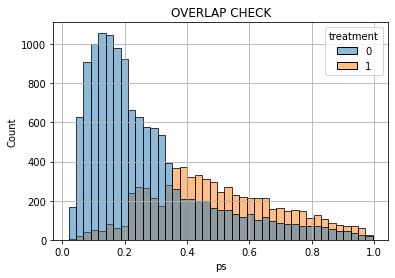

In [275]:
# propensity score calc 
ps_model = LogisticRegression(C=1e6).fit(df.drop(columns=['y', 'treatment']), df.treatment)
df['ps'] = ps_model.predict_proba(df.drop(columns=['y', 'treatment']))[:, 1] # вероятность принадлежности к классу T=1

# overlap check
plt.grid()
plt.title('OVERLAP CHECK')
sns.histplot(data=df, x='ps', hue='treatment')

# теперь можно перейти y(T, X) = y(T, ps)
# матчинг на основе kNN (ищем ближайшего по ps оппонента - сравниваем)
treated = df[df.treatment == 1]
untreated = df[df.treatment == 0]

mt_tr = KNeighborsRegressor(n_neighbors=1).fit(treated[['ps']], treated.y)
mt_untr = KNeighborsRegressor(n_neighbors=1).fit(untreated[['ps']], untreated.y)
untreated['y_match'] = mt_tr.predict(untreated[['ps']])
treated['y_match'] = mt_untr.predict(treated[['ps']])
dfs = pd.concat([treated, untreated])

# ATE = какой был бы эффект если б каждый элемент всей выборки сконвертился T=0 -> T=1
print(f"""ATE_PSM = {np.mean((2*dfs["treatment"] - 1)*(dfs['y'] - dfs["y_match"]))}""")

In [281]:
dfs.treatment.value_counts()

0    13076
1     6924
Name: treatment, dtype: int64

In [276]:
df[df.treatment == 1].y.mean() - df[df.treatment == 0].y.mean()

16.895799546498726

In [277]:
# Аналогичный kNN матчинг по ps через библиотеку
from causalinference import CausalModel
cm = CausalModel(
    Y=df.y.values,
    D=df["treatment"].values, # T
    X=df.ps.values
)
# cm.est_via_matching(matches=1, bias_adj=True)
cm.est_via_matching(matches=1, bias_adj=False)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      7.330      0.288     25.490      0.000      6.767      7.894
           ATC      9.109      0.371     24.535      0.000      8.381      9.836
           ATT      3.972      0.306     12.972      0.000      3.372      4.572



In [284]:
df = pd.read_csv('./data/medicine_impact_recovery.csv').rename(columns={'medication':'treatment', 'recovery':'y'}).drop(columns='severity')

# используем функцию из help_tools
df2m = ci.get_psm_df(df[df.treatment == 0], df[df.treatment == 1], 
                  features_excl=['y', 'treatment'], ps_model = LogisticRegression(C=1e6))

df1m = ci.get_psm_df(df[df.treatment == 1], df[df.treatment == 0], 
                  features_excl=['y', 'treatment'], ps_model = LogisticRegression(C=1e6))

# ATE = усредненный эффект по выборкам group2_matched - group1 + group1_matched-group2
np.mean(np.append(df2m.y.values - df[df.treatment == 0].y.values, df[df.treatment == 1].y.values - df1m.y.values))

#### IPTW

IPTW = Inverse probability of treatment weighting  
У нас есть две группы control и test, которые не сбалансированы, т.е распределение X в них разное.  
Это значит что есть такие слои значений dX семлпы с которыми чаще представлены в control и наоборот.  
Можно это рассмотреть так: клиенты со свойствами X~dX с меньшей вероятностью получают T=1.  
Пример: половине пациентов даем лекарство, но из них есть молодые которые меньше его принимают итд.  
  
Оценим ps(X) - шанс получить T=1 когда у семпла вектор признаков X.  
Два подхода к балансировке.  
1. PSM. Для каждого семпла X и T=1 подбираем зеркальный семпл X2: ps(X2)~ps(X) у которого T=0,   
если ps->0 или 1 значит у этого семпла нет пары, выкидываем семплы с экстремальными ps  
2. IPTW. Вес каждого семпла с ps(X) при расчете вклада в метрику Y рассчитываем как w=1/ps|T=0 или 1/(1-ps)|T=0  
То есть чем меньше был шанс оказаться в той группе, где оказался семпл - тем больше его вес.  
Это позволяет выровнять случаи когда для какого то интервала dX почти все семлпы в тесте или контроле.  
При этом мы не выбрасываем данные.  
  
ATE = avg(Y|X,T=1) - avg(Y|X,T=0) = avg(Y * T / ps) - avg(Y * (1 - T) / (1 - ps)) = avg(Y * (T - ps) / ps (1 - ps))  
Напомним, что ATE = эффект от влияния T=1 если бы оно коснулось всех элементов выборки.  
  
Приложение:  
Как и для PSM критично условие overplap>0. Если у семпла ps=0 и он не представлен в выборке T=0, то нельзя его отмасштабировать  
  
Приложение 2:  
PSM работает неплохо на малых выборках, тогда как для IPTW необходимы большие выборки.  
В противном случае, т.к мы учитываем вклад семплов с экстремальными ps ~ 0, будут искажения в результатах.  
  
Реализацию iptw в python см в разделе "Сравнение моделей"

In [ ]:
# df = pd.read_csv('./data/smoker.csv').rename(columns={'outcome':'y'})
df = pd.read_csv('./data/groupon.csv')[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'treatment', 'revenue']].rename(columns={'revenue':'y'})
# df = pd.read_csv('./data/medicine_impact_recovery.csv').rename(columns={'medication':'treatment', 'recovery':'y'})
df.head(1)

In [ ]:
# ps calc
ps_model = LogisticRegression(C=1e6).fit(df.drop(columns=['y', 'treatment']), df.treatment)
df['ps'] = ps_model.predict_proba(df.drop(columns=['y', 'treatment']))[:, 1] 
plt.grid()
plt.title('OVERLAP CHECK')
sns.histplot(data=df, x='ps', hue='treatment')
# IPTW calc
weight = ((df.treatment - df.ps) / (df.ps * (1 - df.ps)))
# ATE calc
print(f'ATE_IPTW = {np.mean(weight * df.y)}')

#### Сравнение PSM, IPTW, DOUBLY ROBUST

In [305]:
# Bootstrap позволяет оценить доверительные интервалы для ATE для нерегрессионных моделей.  
# При этом довольно проблематично оценить качество построения ps, здесь еще много открытых вопросов

# ДАННЫЕ
# df = pd.read_csv('./data/smoker.csv').rename(columns={'outcome':'y'})
# df = pd.read_csv('./data/groupon.csv')[['prom_length', 'price', 'discount_pct', 
#                                         'coupon_duration', 'featured', 
#                                         'treatment', 'revenue']].rename(columns={'revenue':'y'})
df = pd.read_csv('./data/learning_mindset.csv').rename(columns={'intervention' : 'treatment',
                                                                'achievement_score' : 'y'})
X = df.drop(columns=['treatment', 'y']).columns.values
Y = 'y'
T = 'treatment'
# todo - категориальные пременные

In [ ]:
# линейная регрессия
s = 'treatment'
for j in range(0, len(df[X].columns)):
    s = s + f' + {df[X].columns[j]}'
model = smf.ols(f'y ~ {s}', data=df).fit() # OLS в R-нотации
pd.DataFrame((model.summary().tables[1]))[:4]

In [ ]:
# базовый матчинг
def based_mathing(df, X, T='treatment', Y='y'):
    cm = CausalModel(
        Y=df[Y].values, 
        D=df[T].values,  #T
        X=df[X].values
    )
    cm.est_via_matching(matches=1, bias_adj=True)
    return cm.estimates['matching']['ate']

def psm(df, X, T='treatment', Y='y'):
    df['ps'] = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1] 
    cm = CausalModel(
            Y=df[Y].values, 
            D=df[T].values,  #T
            X=df.ps.values
        )
    cm.est_via_matching(matches=1, bias_adj=True)
    return cm.estimates['matching']['ate']

def iptw(df, X, T='treatment', Y='y'):
    df['ps'] = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1] 
    # IPTW calc
    weight = ((df.treatment - df.ps) / (df.ps * (1 - df.ps)))
    return np.mean(weight * df.y)

# Комбинация регрессионной и IPTW модели. Дает верный прогноз если верна хотя бы одна из моделей
# часть формулы с неверной модели зануляется исходя из возникающего bias оценки (например когда OLS дает плохой предикт Y)
def doubly_robust(df, X, T='treatment', Y='y'):
    # PSM
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # OLS estimator
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    
    # ATE по комбинации двух моделей
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
# psm - достаточно долгая процедура, лучше работает для небольших выборок
np.random.seed(88)
# ates = [psm(df.sample(frac=1, replace=True), X) for j in range(500)]
np.percentile(ates, 2.5), np.percentile(ates, 97.5)

In [ ]:
# микс IPTW + regression; работает быстро
np.random.seed(88)
ates = [doubly_robust(df.sample(frac=1, replace=True), X) for j in range(500)]
np.percentile(ates, 2.5), np.percentile(ates, 97.5)

In [ ]:
# IPTW работает относительно быстро
np.random.seed(88)
ates = [iptw(df.sample(frac=1, replace=True), X) for j in range(500)]
np.percentile(ates, 2.5), np.percentile(ates, 97.5)

In [307]:
# изначальное "расстояние" между фичами датасетов
df1 = df[df.treatment == 0]; df2 = df[df.treatment == 1]
ci.check_cohen_stat(df1, df2, features_excl=['y', 'treatment'])[0]

,feature,avg1,avg2,cohen_d_percent
0,schoolid,39.9586,39.7444,0.89
1,success_expect,5.2223,5.3629,-12.56
2,ethnicity,5.241,5.1859,1.39
3,gender,1.4988,1.4716,5.43
4,frst_in_family,0.6461,0.5996,9.64
5,school_urbanicity,2.4423,2.4592,-1.23
6,school_mindset,-0.0094,-0.1048,9.85
7,school_achievement,0.0367,0.0924,-5.96
8,school_ethnic_minority,-0.0878,-0.0925,0.48
9,school_poverty,-0.0381,-0.0622,2.49


,feature,avg1,avg2,cohen_d_percent
0,schoolid,39.9586,40.251,-1.22
1,success_expect,5.2223,5.2405,-1.61
2,ethnicity,5.241,4.8647,9.74
3,gender,1.4988,1.5145,-3.14
4,frst_in_family,0.6461,0.6566,-2.22
5,school_urbanicity,2.4423,2.4404,0.13
6,school_mindset,-0.0094,-0.0078,-0.16
7,school_achievement,0.0367,0.0477,-1.18
8,school_ethnic_minority,-0.0878,-0.0801,-0.8
9,school_poverty,-0.0381,-0.0459,0.8


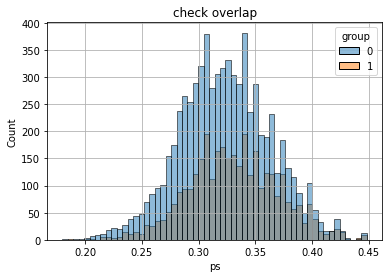

In [308]:
df2m = get_psm_df(df1, df2, features_excl=['rand', 'y', 'treatment'], plot_overlap=True)
# проверяем насколько хорошо сбалансировались датасеты
# cohen_d < 20% хороший результат; более того каждая отдельная фича сбалансирована по cohen<10%
ci.check_cohen_stat(df1, df2m, features_excl=['y', 'treatment'])[0]

#### DID (Diff-in-Diff)

https://www.kaggle.com/code/harrywang/difference-in-differences-in-python/notebook  
https://stats.stackexchange.com/questions/160359/difference-in-difference-method-how-to-test-for-assumption-of-common-trend-betw  
Метод, который используется для оценки влияния изменения на метрику в парадигме до/после.  
Мы ищем параллельный данной метрике тренд (мб из соседнего сегмента) на предыстории -  
и затем в предположении что на параллельный тренд изменение не распространяется, используем  
его в качестве сравнительного контроля (а точнее разницу между трендами до/после)

diff_in_diff = did = (y_exp_avg_after - y_exp_avg_before) - (y_control_avg_after - y_control_avg_before)  

<u> linear regression: </u>  
y = b0 + b1 * exp_group + b2 * dt + b3 * exg_group * dt  
(или y ~ exp_group + dt + exp_group * dt)  
exp_group = 1 if exp else 0  
dt = 1 if after else 0

y_control_avg_before = b0 ; y_control_avg_after = b0 + b2  
y_exp_avg_before = b0 + b1 ; y_exp_avg_after = b0 + b1 + b2 + b3  
did = (y_exp_after - y_exp_before) - (y_control_after - y_control_before) = b3  
  
В парадигме ATE: exp_group * dt = Treatment; Т.е Treatment = 1 -> exp_after; Treatment = 0 -> con_before.  
  
Приложение:  
Оценку дов. интервалов для did можно провести через бутстрап либо F-критерий коэф. b3 в рамках линейной регрессии.  
did = отклонение от параллельности тренда; если тренды остались параллельны (T не подействовал) -> p_val(b3>0) > 0.05  
  
Условия применимости:  
Работает только когда, тренды метрик групп con, exp были параллельны ДО целевого воздействия  
Это можно проверить, если брать интервалы time = x;y до time_T и убеждаясь, что b3 ~ 0


<img src="images/diff_n_diff.png" width="400" align="left">  

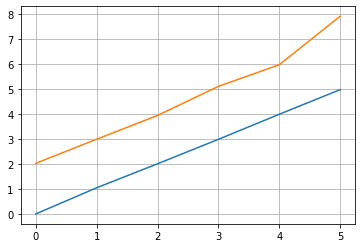

In [3]:
# генерим тестовый датасет формата df = exp_group(0,1); val(metric); dt(after,before->1,0)
df1 = pd.DataFrame({'dt' : np.repeat(list(range(6)), 6*[10])})
df1['val'] = df1['dt'].apply(lambda x: x + np.random.uniform(-0.3, 0.3))
df1['exp_group'] = 0

df2 = df1.copy()
df2['val'] = df2['dt'].apply(lambda x: x + 2 + np.random.uniform(-0.3, 0.3))
df2.loc[df2.dt == 5, 'val'] = df2['val'] + 1
df2['exp_group'] = 1

df = pd.concat([df1, df2], ignore_index=True)
tm1 = df1.groupby('dt').val.mean().reset_index()
tm2 = df2.groupby('dt').val.mean().reset_index()

# как ведут себя средние выборки для двух групп con,exp с течением времени
plt.plot(tm1.dt, tm1.val); plt.plot(tm2.dt, tm2.val); plt.grid()

In [21]:
dt_0, dt_1 = 0, 1
print(f'расчет DID на интервалах dt={dt_0} , dt={dt_1} - нет значимого относительного изменения тренда')
print(ci.calc_did(df[(df.exp_group==0) & (df.dt==dt_0)].val.values, df[(df.exp_group==0) & (df.dt==dt_1)].val.values,
        df[(df.exp_group==1) & (df.dt==dt_0)].val.values, df[(df.exp_group==1) & (df.dt==dt_1)].val.values))
print(' ')
dt_0, dt_1 = 3, 5
print(f'расчет DID на интервалах dt={dt_0} , dt={dt_1} - видим относительный рост')
print(ci.calc_did(df[(df.exp_group==0) & (df.dt==dt_0)].val.values, df[(df.exp_group==0) & (df.dt==dt_1)].val.values,
        df[(df.exp_group==1) & (df.dt==dt_0)].val.values, df[(df.exp_group==1) & (df.dt==dt_1)].val.values))

расчет DID на интервалах dt=0 , dt=1 - нет значимого относительного изменения тренда
{'did': -0.0828103334103748, 'did_confint': (-0.3035965623237821, 0.13797589550303252), 'pval_did>0': 0.45180343778779164}
 
расчет DID на интервалах dt=3 , dt=5 - видим относительный рост
{'did': 0.8193870817156168, 'did_confint': (0.5793716387471851, 1.0594025246840486), 'pval_did>0': 4.13454900314786e-08}


In [ ]:
# выбираем сравниваемые два интервала
def get_slice(df, dt1, dt2):
    tmp = df[df.dt.isin([dt1, dt2])]
    tmp.loc[tmp.dt == dt1, 'dt'] = 0; tmp.loc[tmp.dt == dt2, 'dt'] = 1
    return tmp

# расчет Dif-in-Dif аналитически
def did_calc(df):
    return (df.loc[(df.dt == 1) & (df.exp_group == 1)].val.mean() - df.loc[(df.dt == 0) & (df.exp_group == 1)].val.mean()) - \
            (df.loc[(df.dt == 1) & (df.exp_group == 0)].val.mean() - df.loc[(df.dt == 0) & (df.exp_group == 0)].val.mean())

# оценка эффекта через лин регрессию
def model_calc(df, dt_int=(0,1)):
    model = smf.ols('val ~ exp_group + dt + exp_group * dt', data=df).fit()
    return dt_int, model.params.loc['exp_group:dt'], model.pvalues.loc['exp_group:dt'], (model.conf_int().loc['exp_group:dt'][0], model.conf_int().loc['exp_group:dt'][1])

tmp = get_slice(df, 0 ,1)
print('did = ', did_calc(tmp))
print('b3_ols = ', model_calc(tmp)[1], '; p_val(b3>0) = ', model_calc(tmp)[2])

In [ ]:
df_stat = pd.DataFrame(None, columns=['dt_1_2', 'coef', 'pval', 'confint']); j=0
for dt_int in ([0,1], [1,2], [2,3], [3,4], [4,5]):
    tmp = get_slice(df, dt_int[0], dt_int[1])
    res = model_calc(tmp, dt_int)
    df_stat.loc[j,:] = res; j+=1
print('Видим что до момента 4-5 тренды были параллельными; далее произошло отклонение от тренда (см график выше)')
df_stat

In [ ]:
# покажем что бутстрап did дает тоже самое что регрессия (больше данных - ближе точность)
tmp = get_slice(df, 4, 5) # берем пример сравниваемых интервалов
print('OLS conf = ', np.round(model_calc(tmp)[3], 4))

did_list = []
for j in range(700):
    tmp_boot = tmp.sample(frac=1, replace=True) # генерим датасет с аналогичным распределением
    did_list.append(did_calc(tmp_boot))
print('BOOT conf = ', np.round(np.percentile(did_list, 2.5), 4), np.round(np.percentile(did_list, 97.5), 4))

#### SYNTHETIC CONTROL

https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html - основная глава в книге  
https://medium.com/towards-data-science/causal-inference-with-synthetic-control-in-python-4a79ee636325 - доп статья

In [1]:
# с 1980х в Калифорнии резко увеличили цену (retail price) за пачку сигарет - стремясь минимизировать курение
cigar = pd.read_csv('./data/synth_control_smoking.csv')
cigar[cigar.state == 'California'][['year', 'retprice']].plot(x='year', y='retprice')
cigar['after_treatment'] = cigar.year < 1988
cigar.drop(columns=['beer', 'lnincome', 'age15to24'], inplace=True)
# cigar[cigar.state == 'California'][['year', 'cigsale']].plot(x='year', y='cigsale')
plt.grid()

NameError: name 'pd' is not defined

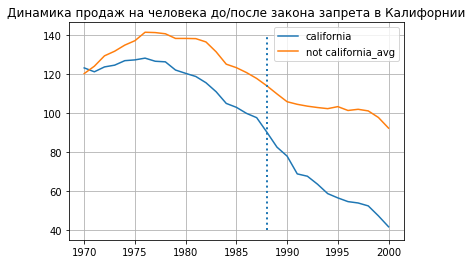

In [3]:
plt.plot(cigar[cigar.state == 'California'].year, cigar[cigar.state == 'California'].cigsale)
tmp = cigar[cigar.state != 'California'].groupby('year').cigsale.mean().reset_index()
cigar['state'] = cigar.state.tolist()
plt.plot(tmp.year, tmp.cigsale)
plt.grid()

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.title('Динамика продаж на человека до/после закона запрета в Калифорнии')
plt.legend(['california', 'not california_avg'])

По графику мы видим примерно, что в наблюдается ускорение расхождения в потреблении  
в Калифорнии и других штатах после принятия закона, однако нельзя оценить точно.  
Synthetic control - метод построения искуственного контроля (в данном случае штата),   
который ведет себя очень похоже на Калифорнию до изменений - и с большой вероятностью  
моделирует поведение после изменений как если бы их не было.

---
Ключевая идея - мы считаем, что метрику по целевому штату (Калифорния) можно разложить в базис  
вспомогательных штатов (units) на разных временных отрезках. Т.е до внесения изменения,  
можно сделать искуственный штат = комбинация вспомогательных, который будет очень близок Калифорнии.  

Матрица X - по колонкам моменты времени dt, по строкам - штаты (юниты разложения).  
Вектор Y - целевая метрика = продажи в Калифорнии во времени. 
Подбираем веса в тренировке X * w = Y.  
Добиваемся чтобы до интервенции предикт был хороший - используем экстраполяцию на период после.  

PS. Для двух переменных регрессия по векторам x1; x2 ищет коэф. чтобы y = k1 * x1 + k2 * x2  
Каждый вектор x1 = (a1 a2 a3 ... an) - можно рассматривать как набор координат во времени.  
Тогда для каждого "момента времени" y_t = k1 * x1_t + k2 * x2_t и.т.д  
Найдем k1; k2 - можем экстраполировать y_t_next по имеющимся x1_t_next; x2_t_next в будущем.  
Мы через регрессию ищем k1; k2; ... kn для n юнитов разложения (т. е n штатов)  

Важно также помнить о том что при большом кол-ве юнитов (aka предикторов)  
линейная регрессия легко переобучается -> нужна регуляризация.

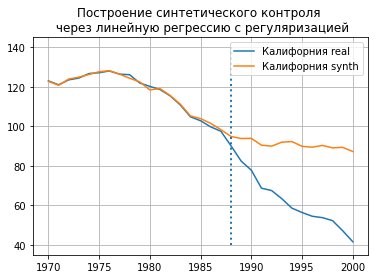

In [13]:
dfs = pd.pivot_table(cigar, 
                    index='year', 
                    columns='state', 
                    values=['cigsale'], 
                    aggfunc=np.mean)['cigsale'].reset_index()

df = dfs[dfs.year <= 1985].copy() # train
# df = dfs[dfs.year <= 1988].copy() # train

y = df['California'].values
X = df.drop(columns='California').values

# обучаем регрессию - получаем коэффициенты k1;k2... для каждого штата
# model_ = LinearRegression(fit_intercept=False).fit(X, y) # без регуляризации - переобучение
model_ =  Lasso(fit_intercept=False, alpha=1.0).fit(X, y) # регуляризация по дефолту

# экстраполируем данные на весь период времени
synth = model_.predict(dfs.drop(columns=['California']).values)
real = dfs.California.values
plt.plot(dfs.year.values, real)
plt.plot(dfs.year.values, synth)
plt.grid()
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.title('Построение синтетического контроля \n через линейную регрессию с регуляризацией')
plt.legend(['Калифорния real', 'Калифорния synth'])

Проблема регрессии - она экстраполирует, не учитывая "схожесть" регионов друг с другом.  
Например, один из весов модели может быть -100 и уносить показатели одного из штатов в несущ. область.  
Чтобы это избежать - можно находить оптимальные веса оптимизацией (метод взвешенных средних),  
накладывая смысловые ограничения вроде - **сумма всех весов равна 1, веса положительные**.  
Это будет лучше учитывать общую специфику и <u>изначальную схожесть</u> данных в используемом базисе.  
Теперь физический смысл весов - нечто схожее с вероятностью.

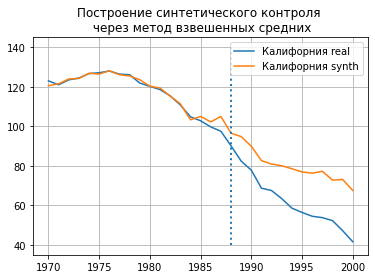

In [14]:
# Реализация метода взвешенных средних через scipy оптимизацию
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))
def get_w(X, y):
    w_start = [1/X.shape[1]]*X.shape[1]
    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights
calif_weights = get_w(X, y)
# строим
synth = dfs.drop(columns=['California']).values.dot(calif_weights)
real = dfs.California.values
plt.plot(dfs.year.values, real)
plt.plot(dfs.year.values, synth)
plt.grid()
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.title('Построение синтетического контроля \n через метод взвешенных средних')
plt.legend(['Калифорния real', 'Калифорния synth'])

#### REGRESSION DISCONTINUITY DESIGN (RDD)

RDD - метод оценки эффекта от влияния в режиме до/после по изменению поведения метрики Y на границе влияния.  
Исследуем зависимость Y(X); при этом считаем что начиная с X>X_thr возникает оцениваемое влияние.  
Пример: зависимость смертности Y от возраста X до/после возраста легализации алкоголя X_thr  
Если на границе X_thr происходит незапланированный скачок -> мера скачка = влияние переменной Z (алкоголь).  
Приближение: считаем, что без наличия влияние нет резкого разрыва -> Y(X) зависит в окрестности X_thr гладко.  
  
Тогда сместим нашу переменную X_ = X - X_thr в точку 0 для удобства.  
Если бы влияния не было -> Y(X_ - alpha) ~ Y(X_ + alpha); alpha -> 0  
D = 1, когда X_>0; 0 когда X_<0 (пороговая функция)
Тогда Y ~ X_ + D + D * X_ (линейная регрессия для близких к порогу значений X_).  
ATE = Y_after - Y_before = (a1 * X_ + a2 * D + a3 * D * X_)_after - (a1 * X_ + a2 * D + a3 * D * X_)_before  
ATE = a2 * (D_after - D_before) = a2.  
  
Сама методика работы с линейной регрессией схожа с методом оценки DID. Только DID = a3.  
DID - оценивает эффект вмешательства a3 повлиявший на темп роста Y после влияния.  
RDD - эффект разрыва a2, который произошел в момент thr начала действия влияния.  

---
<u>Регрессия с весами</u>  
Т.к мы задаем значения на границе до/после порога - регрессия может много влияния уделить подгонке  
под линию точек которые дальше от порога и меньше внимания уделить оценке точности разрыва на пороге влияния.  
Идея - ввести веса, которые снижаются по мере удаления от границы threshold.  

---
<u>Нечеткая граница</u>  
В примере выше предполагали что пороговая функция выглядит как D = 1 if X > thr 0 if X < thr  
Однако, возможно такое, что при X > thr функция D будет иметь вероятностную природу  
Например: не все после выпуска из университета получили диплом (чекаем влияет ли диплом на заработок).  
В этом случае надо использовать техники из IV (instrumental variables) и для оценки использовать Wald Estimator.  

---
<u>Фрод на границе</u>  
Иногда на граничных участках могут наблюдаться аномалии, когда например юзерам выгодно оказываться по одну  
или по другую сторону границы (хотя без дополнительных действий они оказывались бы на противоположной стороне).  
К примеру, занижение доходов выше/ниже уровня повышения налога итд.  
Это можно проверить на графике на наличие всплесков, сгустков плотности клиентов вблизи границы.  
Если данной аномалии не наблюдается - то RDD можно применять.

In [22]:
# датасет - влияние алкоголя на уровень смертности на границе "до/после" возраста легализации алкоголя
# agecell - возраст человека; all - смертность от всех зафиксированных причин
df = pd.read_csv('./data/drinking.csv')
df["agecell"] -= 21 # thr = 21 -> приводим переменную к виду X_
df['D'] = (df["agecell"] > 0).astype(int) # D
model = smf.wls("all ~ agecell * D + D + agecell", df).fit()
model.summary().tables[1] # a2 = coef(D) = 7.66; p_val < 0.05

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
D,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:D,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


In [50]:
print('Видим что до/после 20 лет смертность значимо не росла')
print(ci.calc_rdd(df['all'].values, df.agecell.values, 20))
print(' ')
print('До/после 21 года смертность значимо выросла rdd~7пп! влияние отмены запрета на алкоголь')
print(ci.calc_rdd(df['all'].values, df.agecell.values, 21))

Видим что до/после 20 лет смертность значимо не росла
{'rdd': 0.7146303938942893, 'rdd_confint': (-1.6566844171970239, 3.0859452049856024), 'pval_rdd>0': 0.5467335675976899}
 
До/после 21 года смертность значимо выросла rdd~7пп! влияние отмены запрета на алкоголь
{'rdd': 9.700359216270861, 'rdd_confint': (7.615776390622676, 11.784942041919047), 'pval_rdd>0': 4.656183586700828e-12}
